## PS1
### Li Liu
### 4/28/19

In [127]:
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

import multiprocessing

from dask import compute, delayed
import dask.multiprocessing

1(a)

In [128]:
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')

In [129]:
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0).round(4))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group: [0.0121 0.0082 0.0159 0.014  0.0138 0.0693 0.8667]
Sum of all probabilities 1.0


<IPython.core.display.Javascript object>


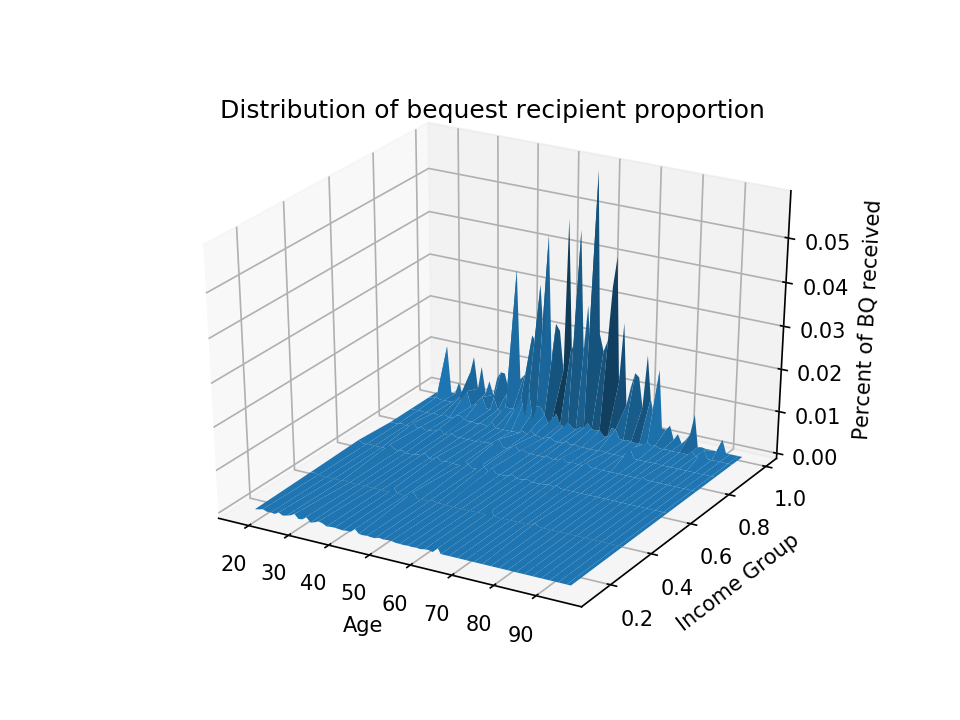

In [130]:
age_vec = np.arange(18,96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

1(b)

In [131]:
#Flatten the data
a=np.empty(0)
for i in range(18,96):
    a=np.append(a, np.ones(7)*i)
    
I=np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
I=np.tile(I, 78)

Mat=pd.DataFrame({"Age":a,"Income Group":I,"Prob":bq_data.flatten()})
Mat.head()

,Age,Income Group,Prob
0,18.0,0.25,0.000000
1,18.0,0.25,0.000284
2,18.0,0.20,0.000603
3,18.0,0.10,0.000000
4,18.0,0.10,0.000000


In [132]:
#Data simulation
Sim=pd.DataFrame({"Age":Mat.iloc[0][0],"Income Group":Mat.iloc[0][1]},index=[0])
np.random.seed(10)
for i in range(1,100):
    index=np.random.choice(np.arange(0,546), p=Mat.Prob)
    Sim.loc[i]=[Mat.iloc[index][0],Mat.iloc[index][1]]
Sim.head()

,Age,Income Group
0,18.0,0.25
1,62.0,0.01
2,25.0,0.09
3,58.0,0.01
4,62.0,0.01


<IPython.core.display.Javascript object>


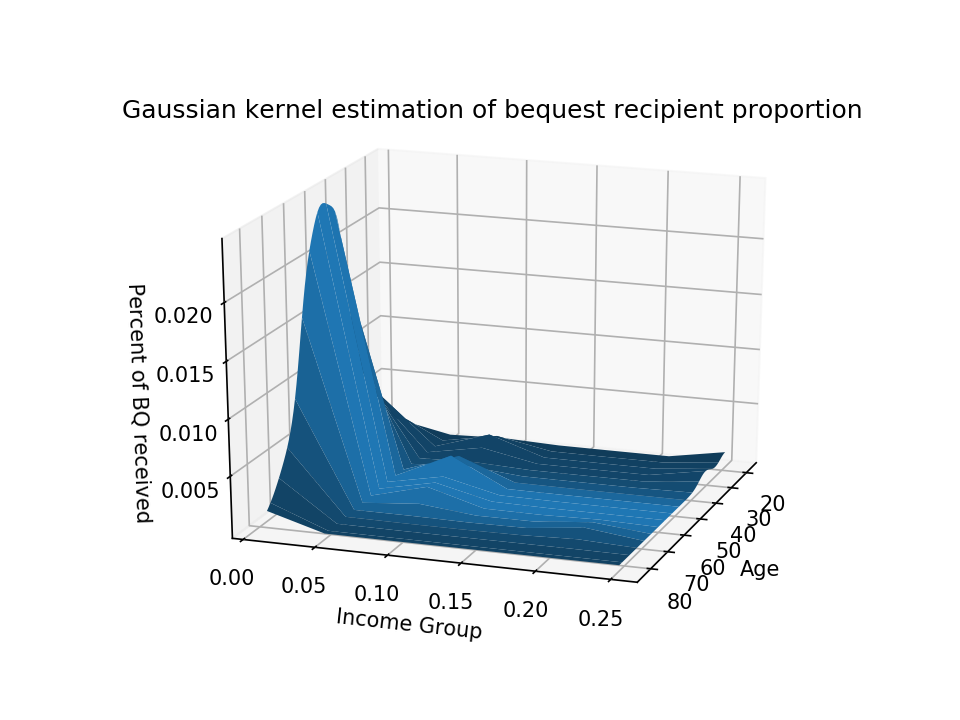

In [133]:
#kernel density estimation
age_mat = Sim['Age']
income_mat = Sim['Income Group']
bandwidth = 0.3
kernel = gaussian_kde(Sim.T, bw_method=bandwidth)

age_mat_min = age_mat.min()
age_mat_max = age_mat.max()
income_mat_min = income_mat.min()
income_mat_max = income_mat.max()

age_mat_i, income_mat_i = np.mgrid[age_mat_min:age_mat_max:78j,
                              income_mat_min:income_mat_max:7j]
coords = np.vstack([item.ravel() for item in [age_mat_i, income_mat_i]])

# kernel(coords)

Z = np.reshape(kernel(coords), age_mat_i.shape)
Z_scaled = Z / float(np.sum(Z))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat_i, income_mat_i, Z_scaled, rstride=5)
ax.set_title('Gaussian kernel estimation of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

I think the best bandwidth parameter $\lambda$ is 0.3. The Gaussian kernel estimation at this lambda value makes the BQ and age curve almost smooth and highlights that the top 10% income group receives the highest amount of bequests than other income groups.

In [134]:
# What is the estimated density for bequest recipients 
#who are age 61 in the 6th lifetime income category?
Z_scaled[61-18+1][5]

3.859533667670884e-06

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is around 3.85e-06. 

***
*Could use cross-validation to select the optimal lambda.
*Value changes with the sampling random seed and the bandwidth.

2(a)

In [135]:
df=pd.read_csv("data/Auto.csv", na_values='?')
df.dropna(inplace=True)
df['mpg high']=np.where(df['mpg']>= np.median(df['mpg']),1,0)
df['orgn1']=np.where(df['origin']==1,1,0)
df['orgn2']=np.where(df['origin']==2,1,0)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg high,orgn1,orgn2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


In [143]:
time1 = timeit.default_timer()

N = 100
MSE_vec_bs  = []
X=df[['cylinders', 'displacement', 'horsepower', 'weight',
        'acceleration', 'year', 'orgn1', 'orgn2']]

for bs_ind in range(N):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, df['mpg high'], test_size = 0.35,random_state=bs_ind)
    LogReg = LogisticRegression().fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE = np.mean((y_test - y_pred) ** 2)
    MSE_vec_bs.append(MSE)


MSE_bs = np.mean(MSE_vec_bs)
MSE_bs_std = np.std(MSE_vec_bs)

time2 = timeit.default_timer()

print('Test estimate MSE bootstrap=', round(MSE_bs,5))
print('Test estimate MSE bootstrap standard err=', round(MSE_bs_std,5))
print('Seconds for computation',time2-time1)

Test estimate MSE bootstrap= 0.10145
Test estimate MSE bootstrap standard err= 0.02171
Seconds for computation 0.44934790000024805


2(b) Use Dask to parallelize these bootstraps

In [144]:
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

Number of available cores is 4


In [146]:
def logistic(bs, seed, data):
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, df['mpg high'], test_size = 0.35, random_state = seed)
    LogReg = LogisticRegression().fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE = ((y_test - y_pred) ** 2).mean()
    return MSE

start_time = timeit.default_timer()

lazy_values = [delayed(logistic)(i,i,df) for i in range(100)]

results_par = compute(*lazy_values, scheduler=dask.multiprocessing.get, num_workers=num_cores)

MSE_bs2 = np.mean(results_par)
MSE_bs_std2 = np.std(results_par)

end_time= timeit.default_timer()

print('Test estimate MSE bootstrap=', MSE_bs2)
print('Test estimate MSE bootstrap standard err=', MSE_bs_std2)

print('Seconds for computation=', end_time-start_time, 'seconds')

Test estimate MSE bootstrap= 0.10144927536231885
Test estimate MSE bootstrap standard err= 0.02171496241126333
Seconds for computation= 0.4948555999999371 seconds


The two error rates are the same (around 0.1).

The computation time is round 0.45, which is slightly smaller than the serial computation in most of the times.